# First example to show how to use pySOT in serial and synchronous parallel for bound constrained optimization problems

## Step 1: Import modules and create pySOT objects (1)-(4)

In [1]:
# Import the necessary modules
from pySOT import *
from poap.controller import SerialController, ThreadController, BasicWorkerThread
import numpy as np

# Decide how many evaluations we are allowed to use
maxeval = 500

# (1) Optimization problem
# Use the 10-dimensional Ackley function
data = Ackley(dim=10)
print(data.info)

# (2) Experimental design
# Use a symmetric Latin hypercube with 2d + 1 samples
exp_des = SymmetricLatinHypercube(dim=data.dim, npts=2*data.dim+1)

# (3) Surrogate model
# Use a cubic RBF interpolant with a linear tail
surrogate = RBFInterpolant(kernel=CubicKernel, tail=LinearTail, maxp=maxeval)

# (4) Adaptive sampling
# Use DYCORS with 100d candidate points
adapt_samp = CandidateDYCORS(data=data, numcand=100*data.dim)

10-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


## Step 2: Launch a serial controller and use standard Surrogate Optimization strategy

In [2]:
# Use the serial controller (uses only one thread)
controller = SerialController(data.objfunction)

# (5) Use the sychronous strategy without non-bound constraints
strategy = SyncStrategyNoConstraints(
        worker_id=0, data=data, maxeval=maxeval, nsamples=1,
        exp_design=exp_des, response_surface=surrogate, 
        sampling_method=adapt_samp)
controller.strategy = strategy

# Run the optimization strategy
result = controller.run()

# Print the final result
print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                precision=5, suppress_small=True)))

Best value found: 1.6473401358349098
Best solution found: [-0.92154 -0.9155   0.00162 -0.00063  0.00569  0.00659  0.00674  0.00265  0.00149 -0.00675]


## Step 3: Make a progress plot

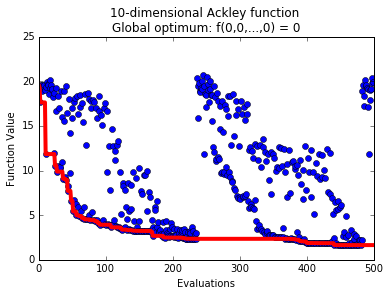

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Extract function values from the controller
fvals = np.array([o.value for o in controller.fevals])

f, ax = plt.subplots()
ax.plot(np.arange(0,maxeval), fvals, 'bo')  # Points
ax.plot(np.arange(0,maxeval), np.minimum.accumulate(fvals), 'r-', linewidth=4.0)  # Best value found
plt.xlabel('Evaluations')
plt.ylabel('Function Value')
plt.title(data.info)
plt.show()

## Step 4: Launch a threaded controller with 4 workers and use standard Surrogate Optimization strategy allowing to do 4 simultaneous in parallel. Notice how similar the code in Step 3 is to the code in Step 2. 

In [4]:
# Reset the surrogate model
surrogate.reset()

# Use the threaded controller
controller = ThreadController()

# (5) Use the sychronous strategy without non-bound constraints
# Use 4 threads and allow for 4 simultaneous evaluations
nthreads = 4
strategy = SyncStrategyNoConstraints(
        worker_id=0, data=data, maxeval=maxeval, nsamples=nthreads,
        exp_design=exp_des, response_surface=surrogate, 
        sampling_method=adapt_samp)
controller.strategy = strategy

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()

# Print the final result
print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                precision=5, suppress_small=True)))

Best value found: 1.011844370224431
Best solution found: [-0.00196  0.0037   0.43201  0.00032 -0.00055  0.00009  0.00129 -0.00069 -0.00115  0.00109]


## Step 5: Make a progress plot

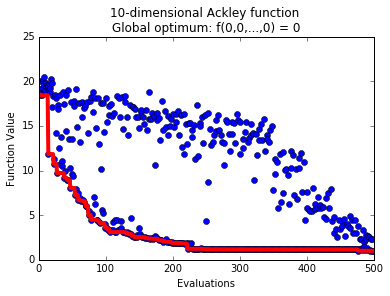

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Extract function values from the controller
fvals = np.array([o.value for o in controller.fevals])

f, ax = plt.subplots()
ax.plot(np.arange(0,maxeval), fvals, 'bo')  # Points
ax.plot(np.arange(0,maxeval), np.minimum.accumulate(fvals), 'r-', linewidth=4.0)  # Best value found
plt.xlabel('Evaluations')
plt.ylabel('Function Value')
plt.title(data.info)
plt.show()

## Exercise: Experiment with pySOT object (1)-(4) and run step 2 and step 3 again.

## Written by, David Eriksson, dme65@cornell.edu